# Bayesian workflow

This tutorial highlights some ideas from https://arxiv.org/abs/1709.01449, including:

* Making a flip book of the prior predictions
* posterior predictive checks



## Model

We again consider the sine model with gaussian measurement errors.

$$ y = A_1 \sin\left(2 \pi \left(\frac{t}{P_1} + t_1\right)\right) + B + \epsilon $$

where $\epsilon \sim \mathrm{Normal}(0, \sigma)$



In [1]:
import numpy as np
from numpy import pi, sin

def sine_model1(t, B, A1, P1, t1):
    return A1 * sin((t / P1 + t1) * 2 * pi) + B



The model has four unknown parameters per component:

* the signal offset $B$
* the amplitude $A$
* the period $P$
* the time offset $t_0$

## Generating data

Lets generate some data following this model:


In [2]:
np.random.seed(42)

n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)
# measurement values
yerr = 1.0
y = np.random.normal(sine_model1(t, B=1.0, A1=0.9, P1=3, t1=0), yerr)

y[0] += 3  # add outlier


## Visualise the data

Lets plot the data first to see what is going on:

<ErrorbarContainer object of 3 artists>

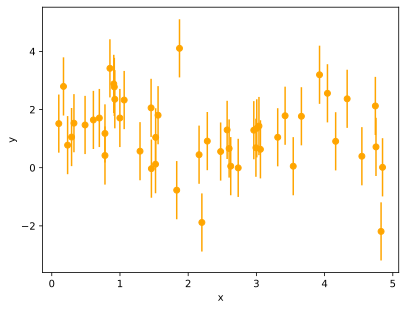

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')


A beautiful noisy data set, with some hints of a modulation.

Given this data set, we should come up with a sensible model.



In [4]:
parameters = ['B', 'A1', 'P1', 't1']

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.1 to 100
    params[1] = 10**(cube[1] * 3 - 1)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params

def log_likelihood(params):
    # unpack the current parameters:
    B, A1, P1, t1 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model1(t, B=B, A1=A1, P1=P1, t1=t1)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()
    
    return loglike



Lets take a few samples from the prior and look if they look anything like data we would expect.

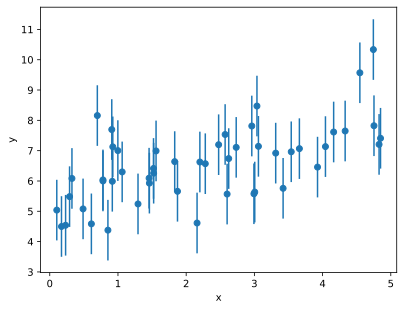

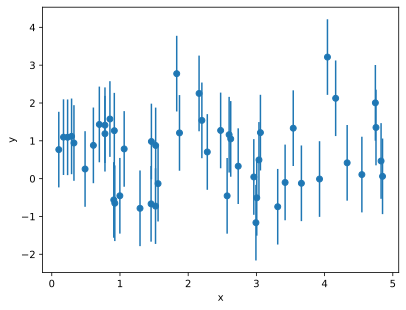

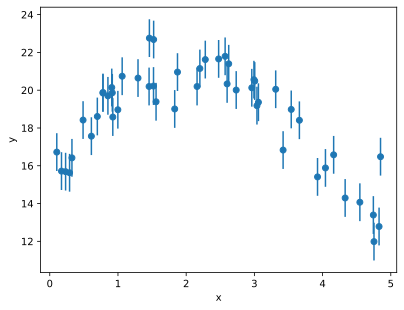

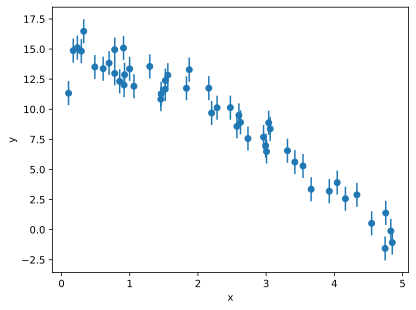

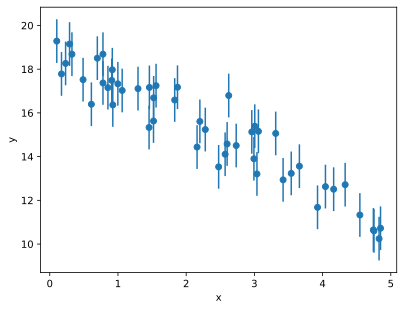

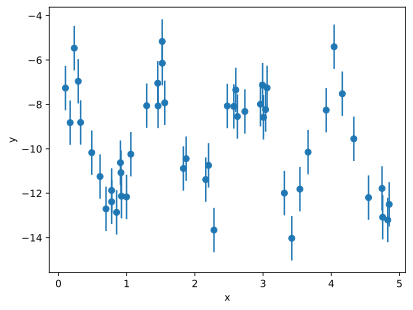

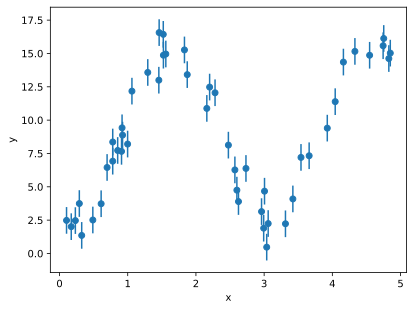

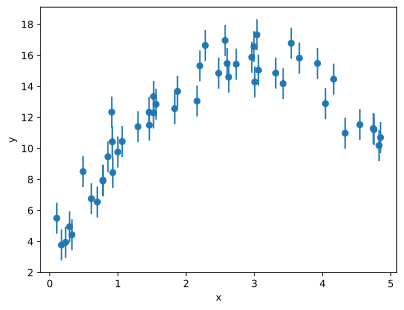

In [5]:
for i in range(8):
    plt.figure()
    cube = np.random.uniform(size=len(parameters))
    params = prior_transform(cube)
    B, A1, P1, t1 = params
    y_model = sine_model1(t, B=B, A1=A1, P1=P1, t1=t1)
    y_sim = np.random.normal(y_model, yerr)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.errorbar(x=t, y=y_sim, yerr=yerr,
                 marker='o', ls=' ')
    

That looks quite OK actually -- the y-ranges are of the right magnitude, the periods are sometimes short, sometimes long.

## Make posteriors

In [6]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)
result = sampler.run()


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01  


[ultranest] Likelihood function evaluations: 149118


[ultranest]   logZ = -38.87 +- 0.08467


[ultranest] Effective samples strategy satisfied (ESS = 3492.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.23, need <0.5)


[ultranest]   logZ error budget: single: 0.14 bs:0.08 tail:0.01 total:0.09 required:<0.50


[ultranest] done iterating.


## Posterior predictive checks

The idea of posterior predictive checks (PPC)
is to generate new data from each posterior sample,
and then verify if they look like the data.

This is a bit circular, but if the model is too rigid,
then some data points cannot be reproduced.


Text(0, 0.5, 'y')

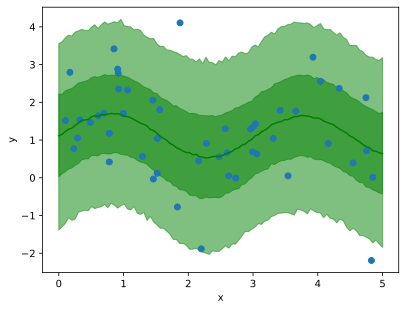

In [7]:
from ultranest.plot import PredictionBand

t_range = np.linspace(0, 5, 100)
band = PredictionBand(t_range)

plt.figure()

for params in result['samples']:
    B, A1, P1, t1 = params
    y_model = sine_model1(t_range, B=B, A1=A1, P1=P1, t1=t1)
    y_sim = np.random.normal(y_model, yerr)
    band.add(y_sim)

band.line(color='g')
band.shade(color='g', alpha=0.5)
band.shade(q=0.49, color='g', alpha=0.5)
    
plt.scatter(t, y, marker='o')
plt.xlabel('x')
plt.ylabel('y');


We nicely see that most data points follow the PPC 99.5% probability range (light green).

**Except** for one point (near x=2, y=4). This is the outlier I snuck in when generating the data.

At this point we could adjust the model.

## Plot the parameter posterior probability distribution

A classic corner plot:

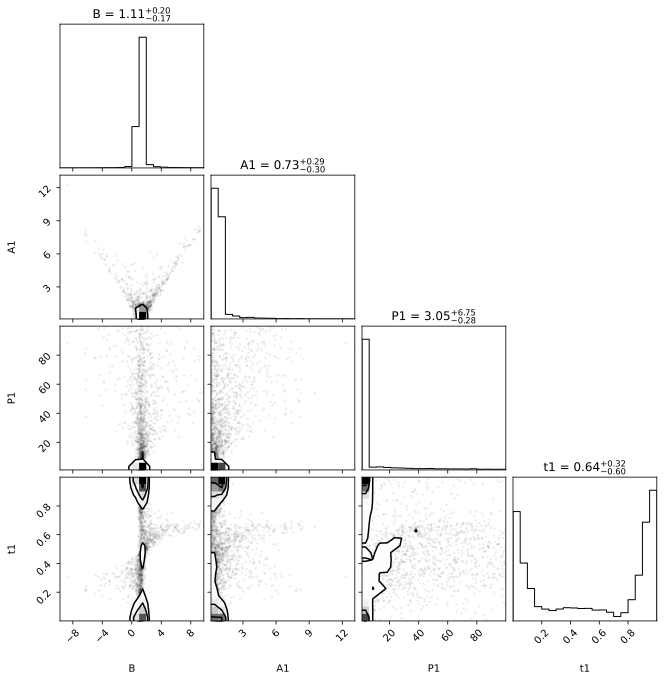

In [8]:
from ultranest.plot import cornerplot
cornerplot(result)

### Next

These were just some of the basic elements of a Bayesian workflow:

* Exploratory data analysis
* Specifying likelihood & priors
* Generating a prior flip-book
* Posterior predictive checks

The other tutorials cover other aspects, such as 

* verifying the model with simulated data
* comparing models


Further reading (more MCMC-related):

* https://mc-stan.org/workshops/stancon2018_intro/Bayesian%20workflow.pdf
* https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html
* https://arxiv.org/abs/1709.01449